In [1]:
import os
import pandas as pd


import glob


import scib
import scanpy as sc
import scvi
import scgen

from pathlib import Path
from data_manage import *

import pymde
from scvi.model.utils import mde

/Users/miaoxinran/anaconda3/envs/scvi-env2/lib/python3.9/site-packages/torchvision/transforms/functional_pil.py:228: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  interpolation: int = Image.BILINEAR,
/Users/miaoxinran/anaconda3/envs/scvi-env2/lib/python3.9/site-packages/torchvision/transforms/functional_pil.py:295: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  interpolation: int = Image.NEAREST,
/Users/miaoxinran/anaconda3/envs/scvi-env2/lib/python3.9/site-packages/torchvision/transforms/functional_pil.py:311: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  interpolation: int = Image.NEAREST,
/Users/miaoxinran/anaconda3/envs/scvi-env2/lib/python3.9/site-packages/torchvision/transforms/functional_pil.py:328: DeprecationWarning: BI

In [2]:
ad_file_paths = glob.glob("../../results/simulation/test/derived_data/human_pancreas_norm_complexBatch/*/*h5ad")
raw_ad_file_paths = glob.glob("../../data/raw_data/*h5ad")

In [ ]:
int_metrics = pd.DataFrame(columns = ["ad", "dataset", "c_type", "n_cell", "cell_times", "seq_depth",
                                      "method", "metric", "evaluation", "fig_path", "hyper_para"])

In [ ]:
for path in ['../../data/raw_data/human_pancreas_norm_complexBatch.h5ad']:
    adata = sc.read(path)
    adata_raw = sc.read(path)
    c_type, n_cell, cell_times, seq_depth = "all", 0, 0, 0
    # train scgen
    for n_latent in [5, 50, 100]: 
        fig_path = "scvi_immune_n_latent_" + str(n_latent)
        model_path ="../../results/scvi_models/" + "immune_" 
        
        sc.pp.highly_variable_genes(
            adata,
            flavor = "seurat_v3",
            n_top_genes = 2000,
            batch_key = "tech",
            subset = True,
            layer="counts"
        )
        scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="tech")
        vae = scvi.model.SCVI(adata, n_layers = 2, n_latent= n_latent, gene_likelihood="nb")
        lvae = scvi.model.SCANVI.from_scvi_model(
            vae,
            adata=adata,
            labels_key="celltype",
            unlabeled_category="Unknown",
        )
        lvae.train(max_epochs= 1, n_samples_per_label=100)


        
        pcr = scib.me.pcr_comparison(adata_pre = adata_raw, adata_post = adata, covariate = "celltype")
        nmi = scib.me.nmi(adata = adata, group1 = "tech",  group2 = "celltype")
        ari = scib.me.ari(adata = adata, group1 = "tech",  group2 = "celltype")
        
        # visualization
        scvi_vis(adata, vae, fig_path)

        int_metrics.loc[len(int_metrics.index)] = ["path", "human_pancreas_norm_complexBatch", c_type, n_cell, cell_times, seq_depth,
                             "scvi", "pcr", pcr, fig_path, n_latent]
        int_metrics.loc[len(int_metrics.index)] = ["path", "human_pancreas_norm_complexBatch", c_type, n_cell, cell_times, seq_depth,
                             "scvi", "nmi", nmi, fig_path, n_latent]
        int_metrics.loc[len(int_metrics.index)] = ["path", "human_pancreas_norm_complexBatch", c_type, n_cell, cell_times, seq_depth,
                             "scvi", "ari", ari, fig_path, n_latent]
    print(int_metrics)
    int_metrics.to_csv("integration_results/scvi_raw.csv")

In [11]:
lvae = scvi.model.SCANVI.from_scvi_model(
    vae,
    adata=adata,
    labels_key="celltype",
    unlabeled_category="Unknown",
)

In [12]:
lvae.train(max_epochs= 1, n_samples_per_label=100)

INFO     Training for 1 epochs.                                                              


/Users/miaoxinran/anaconda3/envs/scvi-env2/lib/python3.9/site-packages/torch/distributed/_sharded_tensor/__init__.py:8: DeprecationWarning: torch.distributed._sharded_tensor will be deprecated, use torch.distributed._shard.sharded_tensor instead
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Epoch 1/1: 100%|██████████| 1/1 [00:07<00:00,  7.13s/it, loss=2.27e+03, v_num=1]


In [13]:
def scanvi_vis(adata, vae, fig_path):
    adata.obsm["X_scANVI"] = vae.get_latent_representation()
    sc.pp.neighbors(adata, use_rep="X_scANVI")
    sc.tl.leiden(adata)
    adata.obsm["X_mde_scanvi"] = mde(adata.obsm["X_scANVI"])
    sc.pl.embedding(
        adata,
        basis="X_mde_scanvi",
        color=["tech", "celltype"],
        frameon=False,
        ncols=1,
        save = fig_path + "scanvi_corrected_latent"
    )


OMP: Info #273: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


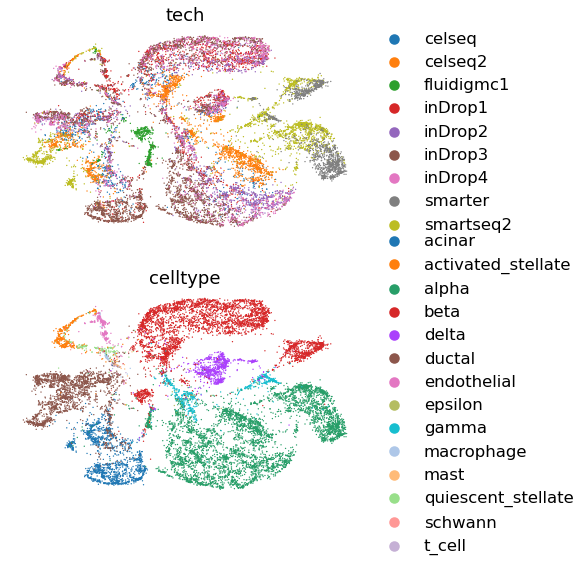

In [14]:
scanvi_vis(adata, lvae, ".")